In [22]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path
import unicodedata


Configuration

In [23]:
excel_path = r"Z:\UriMons\Modulation_Index\Behavior\Grooming_EPA.xlsx"   # <-- replace with your file path
sheet_name = None                         # or a specific sheet name
metrics = ["GroomingTime", "GroomingBouts", "TimePerBout"]
out_dir = Path(excel_path).resolve().parent

# General MI definition:
#   "mean_of_mis" -> mean([MI_Stress, MI_PostStress])
#   "combined_vs_baseline" -> (mean(Stress,Post) - Baseline) / (mean(Stress,Post) + Baseline)
general_mi_method = "mean_of_mis"

# Colors as requested
colors = {"WT": "blue", "KO": "red"}

Helper functions

In [24]:
def normalize_stage(s):
    s = str(s).strip().lower().replace("-", " ").replace("_", " ")
    if "post" in s: return "post_stress"
    if "stress" in s and "post" not in s: return "stress"
    return "baseline"

def symmetric_mi(cond, base, eps=1e-12):
    # bounded [-1, 1], symmetric for increases/decreases
    return (cond - base) / (cond + base + eps)

def wide_by_mouse(df, value_col):
    tmp = df[["Mouse","Genotype","Stage", value_col]].copy()
    tmp["Stage"] = tmp["Stage"].apply(normalize_stage)
    w = tmp.pivot_table(index=["Mouse","Genotype"], columns="Stage",
                        values=value_col, aggfunc="mean")
    for c in ["baseline","stress","post_stress"]:
        if c not in w.columns:
            w[c] = np.nan
    return w.reset_index()

def summarize_and_ttest(df, value_col="MI"):
    """Return per-genotype mean±SEM and Welch p-value (WT vs KO)."""
    g = df.groupby("Genotype")[value_col]
    summary = g.agg(n="count", mean="mean", std="std").reset_index()
    summary["sem"] = summary["std"] / np.sqrt(summary["n"])
    wt = df.loc[df["Genotype"]=="WT", value_col].dropna()
    ko = df.loc[df["Genotype"]=="KO", value_col].dropna()
    if len(wt)>=2 and len(ko)>=2:
        t, p = stats.ttest_ind(wt, ko, equal_var=False, nan_policy="omit")
    else:
        t, p = np.nan, np.nan
    summary["p_value"] = p
    return summary, p

def barplot_mean_sem(ax, summary_df, title, ybounds=None, zero_line=True):
    order = ["WT","KO"]
    means, sems = [], []
    for g in order:
        if g in summary_df["Genotype"].values:
            means.append(summary_df.loc[summary_df["Genotype"]==g,"mean"].values[0])
            sems.append(summary_df.loc[summary_df["Genotype"]==g,"sem"].values[0])
        else:
            means.append(np.nan); sems.append(np.nan)
    ax.bar(order, means, yerr=sems, capsize=6,
           color=[colors[g] for g in order], edgecolor="black", alpha=0.9)
    if zero_line:
        ax.axhline(0, color="black", linewidth=1)
    ax.set_ylabel("Modulation Index (MI)")
    ax.set_title(title)
    if ybounds is not None:
        ax.set_ylim(*ybounds)


Load data

In [25]:
df = pd.read_excel(excel_path, sheet_name="Sheet1", header=0)

print("Columns detected:", df.columns.tolist())

# Normalize values
df["Genotype"] = df["Genotype"].astype(str).str.strip().str.upper()
def normalize_stage(s):
    s = str(s).strip().lower().replace("-", " ").replace("_", " ")
    if "post" in s: return "post_stress"
    if "stress" in s and "post" not in s: return "stress"
    return "baseline"
df["Stage"] = df["Stage"].apply(normalize_stage)

print("✅ Data from Sheet1 loaded successfully!")
print(df.head())

Columns detected: ['Mouse', 'Genotype', 'Stage', 'GroomingTime', 'GroomingBouts', 'TimePerBout']
✅ Data from Sheet1 loaded successfully!
   Mouse Genotype        Stage  GroomingTime  GroomingBouts  TimePerBout
0    175       KO     baseline       95.8000             20     4.790000
1    175       KO       stress        6.5330              3     2.177667
2    175       KO  post_stress      135.6670             11    12.333364
3    176       KO     baseline      217.4670             31     7.015065
4    176       KO       stress       24.9667             10     2.496670


compute per-mouse MIs

In [26]:
rows = []

for metric in metrics:
    w = wide_by_mouse(df, metric)
    mi_stress = symmetric_mi(w["stress"], w["baseline"])
    mi_post   = symmetric_mi(w["post_stress"], w["baseline"])
    # CombinedAbs = average magnitude of change across the two stages
    mi_abs_combined = (mi_stress.abs() + mi_post.abs()) / 2.0

    for mi_vals, mi_type in [
        (mi_stress, "MI_Stress"),
        (mi_post, "MI_PostStress"),
        (mi_abs_combined, "MI_CombinedAbs"),
    ]:
        r = pd.DataFrame({
            "Mouse": w["Mouse"],
            "Genotype": w["Genotype"],
            "Metric": metric,
            "MI_type": mi_type,
            "MI": mi_vals
        })
        rows.append(r)

mi_long = pd.concat(rows, ignore_index=True)


General Grooming MI (per mouse)
average across the three CombinedAbs MIs for the three grooming metrics

In [27]:
combined_df = mi_long[mi_long["MI_type"] == "MI_CombinedAbs"]
pivoted = combined_df.pivot_table(index=["Mouse","Genotype"],
                                  columns="Metric", values="MI",
                                  aggfunc="mean").reset_index()
#pivoted["General_Grooming_MI"] = pivoted[metrics].mean(axis=1, skipna=True)
pivoted["General_Grooming_MI"] = pivoted[["GroomingTime", "GroomingBouts"]].mean(axis=1, skipna=True)


general_mi_long = pivoted[["Mouse","Genotype","General_Grooming_MI"]].copy()
general_mi_long["MI_type"] = "General_Grooming_MI"
general_mi_long["Metric"] = "GroomingBehavior"
general_mi_long = general_mi_long.rename(columns={"General_Grooming_MI":"MI"})

# Append to per-mouse table
mi_long = pd.concat([mi_long, general_mi_long], ignore_index=True)


Save per-mouse MI table before summaries

In [28]:
mi_csv = out_dir / "EPA_MI_per_mouse_tidy.csv"
mi_long.to_csv(mi_csv, index=False)

Summaries (mean±SEM) + Welch tests, and save

In [29]:
summ_records = []
for metric in metrics + ["GroomingBehavior"]:
    for mi_type in ["MI_Stress","MI_PostStress","MI_CombinedAbs"] if metric != "GroomingBehavior" else ["General_Grooming_MI"]:
        sub = mi_long[(mi_long["Metric"]==metric) & (mi_long["MI_type"]==mi_type)].copy()
        summary, p = summarize_and_ttest(sub)
        summary["Metric"] = metric
        summary["MI_type"] = mi_type
        summ_records.append(summary)

summary_table = pd.concat(summ_records, ignore_index=True)[
    ["Metric","MI_type","Genotype","n","mean","sem","std","p_value"]
]

summary_csv = out_dir / "EPA_MI_summary_by_genotype.csv"
summary_table.to_csv(summary_csv, index=False)

print("✅ Saved CSVs:")
print(f" - Per-mouse: {mi_csv}")
print(f" - Summary+stats: {summary_csv}")
print(f"\nFiles saved in: {out_dir}")

✅ Saved CSVs:
 - Per-mouse: \\isi.storwis.weizmann.ac.il\labs\yizharlab\UriMons\Modulation_Index\Behavior\EPA_MI_per_mouse_tidy.csv
 - Summary+stats: \\isi.storwis.weizmann.ac.il\labs\yizharlab\UriMons\Modulation_Index\Behavior\EPA_MI_summary_by_genotype.csv

Files saved in: \\isi.storwis.weizmann.ac.il\labs\yizharlab\UriMons\Modulation_Index\Behavior


Inline plots with p-values

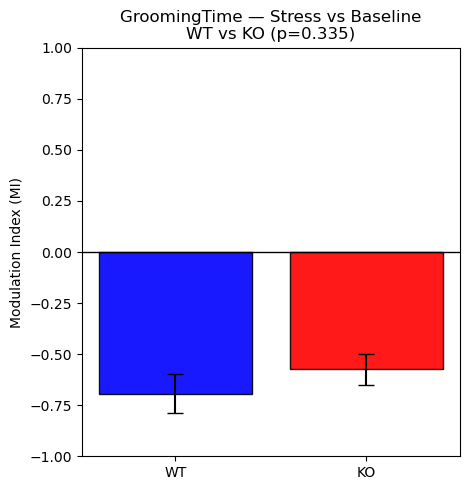

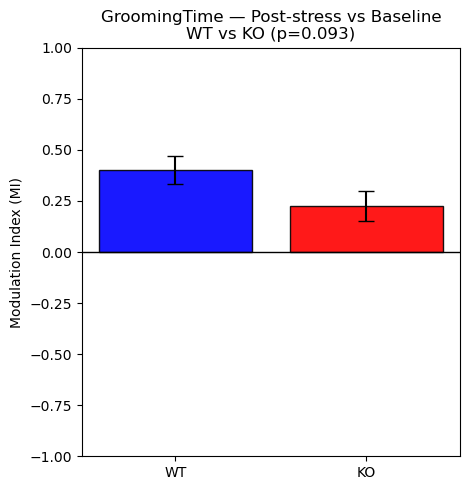

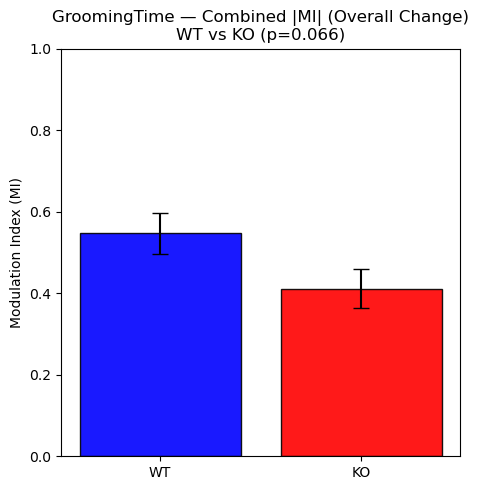

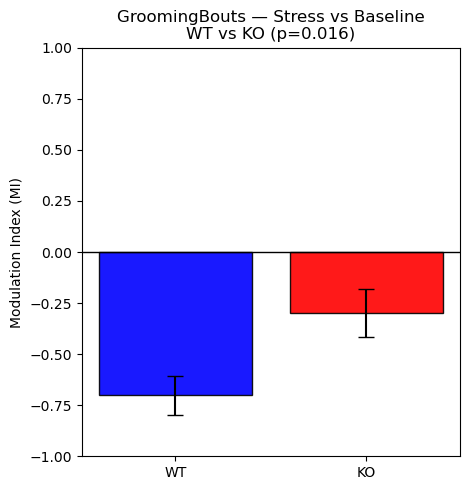

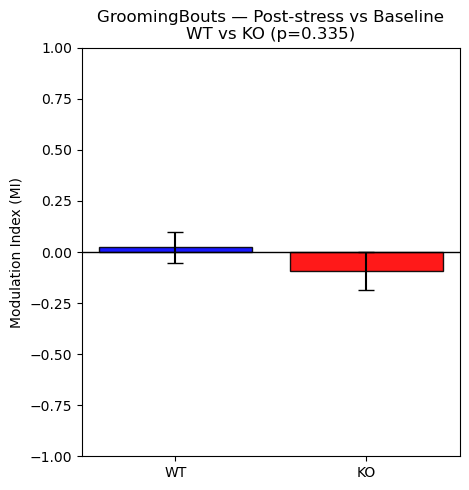

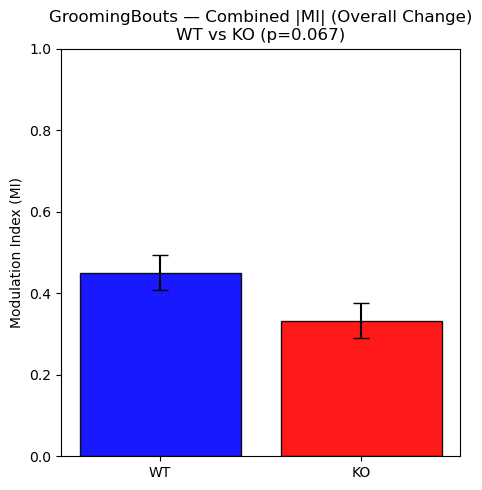

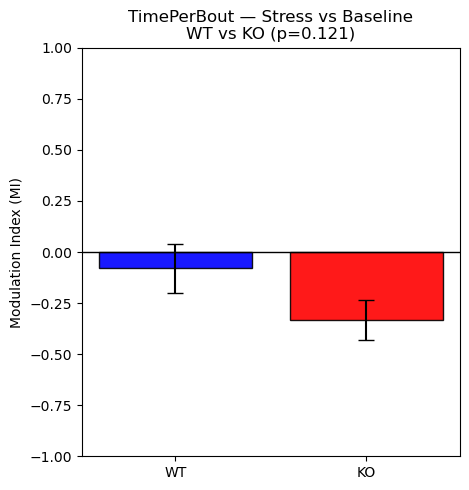

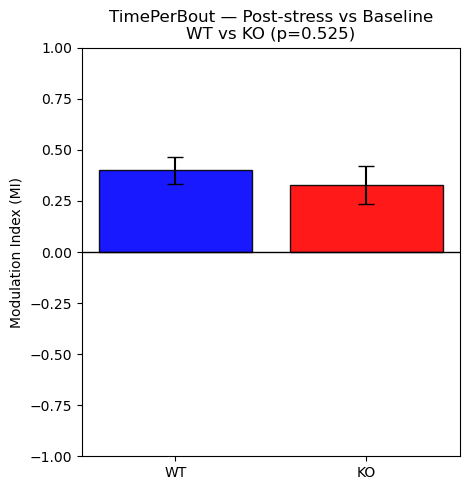

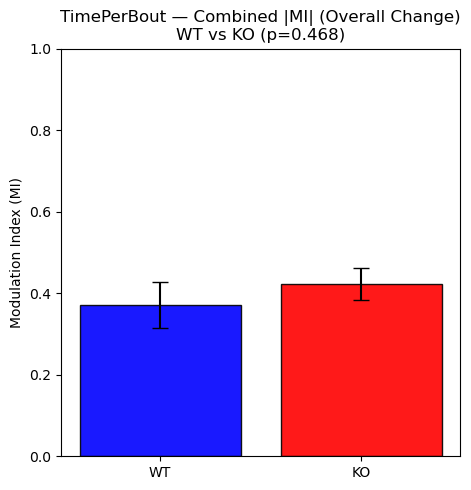

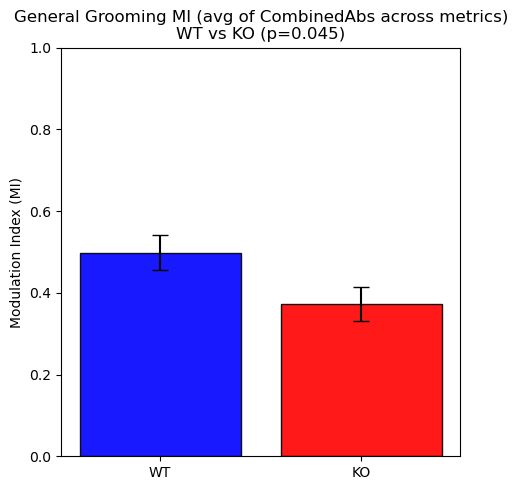

In [30]:
# For MI_* plots (can be negative), use [-1, 1]. For General_Grooming_MI (non-negative), use [0, 1].
for metric in metrics:
    for mi_type, pretty in [
        ("MI_Stress", "Stress vs Baseline"),
        ("MI_PostStress", "Post-stress vs Baseline"),
        ("MI_CombinedAbs", "Combined |MI| (Overall Change)"),
    ]:
        sub_sum = summary_table[(summary_table["Metric"]==metric) & (summary_table["MI_type"]==mi_type)]
        p_val = sub_sum["p_value"].iloc[0]
        fig, ax = plt.subplots(figsize=(4.8, 5))
        # y-limits: standard MI is bounded [-1,1]; CombinedAbs is [0,1]
        ybounds = (-1, 1) if mi_type in ["MI_Stress","MI_PostStress"] else (0, 1)
        zero_line = (mi_type in ["MI_Stress","MI_PostStress"])
        barplot_mean_sem(ax, sub_sum, f"{metric} — {pretty}\nWT vs KO (p={p_val:.3f})",
                         ybounds=ybounds, zero_line=zero_line)
        plt.tight_layout()
        plt.show()

# Plot General Grooming MI
sub_sum = summary_table[(summary_table["Metric"]=="GroomingBehavior") &
                        (summary_table["MI_type"]=="General_Grooming_MI")]
p_val = sub_sum["p_value"].iloc[0]
fig, ax = plt.subplots(figsize=(4.8, 5))
barplot_mean_sem(ax, sub_sum,
                 f"General Grooming MI (avg of CombinedAbs across metrics)\nWT vs KO (p={p_val:.3f})",
                 ybounds=(0, 1), zero_line=False)
plt.tight_layout()
plt.show()

Compact text summary

In [31]:
disp = summary_table.copy()
disp["mean±SEM"] = disp["mean"].round(3).astype(str) + " ± " + disp["sem"].round(3).astype(str)
print("\n=== Summary by Genotype (mean ± SEM, Welch p-values) ===")
print(disp[["Metric","MI_type","Genotype","n","mean±SEM","p_value"]].to_string(index=False))


=== Summary by Genotype (mean ± SEM, Welch p-values) ===
          Metric             MI_type Genotype  n       mean±SEM  p_value
    GroomingTime           MI_Stress       KO 12 -0.573 ± 0.076 0.334831
    GroomingTime           MI_Stress       WT 12 -0.693 ± 0.094 0.334831
    GroomingTime       MI_PostStress       KO 12  0.225 ± 0.073 0.092995
    GroomingTime       MI_PostStress       WT 12  0.401 ± 0.068 0.092995
    GroomingTime      MI_CombinedAbs       KO 12  0.411 ± 0.048 0.066410
    GroomingTime      MI_CombinedAbs       WT 12  0.547 ± 0.051 0.066410
   GroomingBouts           MI_Stress       KO 12   -0.3 ± 0.119 0.015651
   GroomingBouts           MI_Stress       WT 12 -0.701 ± 0.096 0.015651
   GroomingBouts       MI_PostStress       KO 12 -0.094 ± 0.092 0.334972
   GroomingBouts       MI_PostStress       WT 12  0.023 ± 0.075 0.334972
   GroomingBouts      MI_CombinedAbs       KO 12  0.333 ± 0.043 0.067353
   GroomingBouts      MI_CombinedAbs       WT 12  0.451 ± 0.044 0.